# Цели и задачи проекта
Цель проекта - провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. Это позволит: Быстро выявлять перспективных клиентов и предлагать им персонализированные условия. Точно настраивать рекламу на аудитории с высокой вероятностью возврата. Оптимизировать маркетинговые бюджеты. Повысить общий уровень удержания клиентов.

Задачи:

Загрузить данные из PostgreSQL
Провести предобработку данных
Провести анализ данных
Сделать вывод о проведенном анализе
Дать комментарий по стратегии

# Анализ лояльности пользователей Яндекс Афиши

# Этапы выполнения проекта

## Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [3]:
import pandas as pd

In [4]:
from sqlalchemy import create_engine

In [5]:
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt

In [8]:
import phik

In [9]:
from dotenv import load_dotenv
import os
load_dotenv(dotenv_path='./.env')
db_config = {'user': os.getenv('DB_USER'), # имя пользователя
             'pwd': os.getenv('DB_PASSWORD'), # пароль
             'host': os.getenv('DB_HOST'),
             'port': os.getenv('DB_PORT'), # порт подключения
             'db': os.getenv('DB_DATABASE') # название базы данных
             } 

In [10]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 

In [11]:
query = '''
SELECT 
    p.user_id, 
    p.device_type_canonical, 
    p.order_id, 
    p.created_dt_msk AS order_dt, 
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    CASE 
        WHEN LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk) IS NOT NULL 
        THEN DATE_PART('day', p.created_dt_msk - LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk))
        ELSE NULL 
    END as days_since_prev,
    p.event_id,
    e.event_name_code as event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
LEFT JOIN afisha.events AS e ON e.event_id = p.event_id
LEFT JOIN afisha.city AS c ON c.city_id = e.city_id
LEFT JOIN afisha.regions AS r ON r.region_id = c.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY p.user_id ASC
''' 

df = pd.read_sql_query(query, con=engine) 

In [12]:
display(df.head(5)) # Тестируем выгрузку

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

**Датафрейм состоит из 15 столбцов и 290611 строк. Только один столбец days_since_prev не заполнен полностью.**

**Шаги предобработки данных:**

Оптимизировать разрядность:
- order_dt/ts - > astype('datetime64[s]')
- days_since_prev -> astype('float32')

## Предобработка данных

Выполните все стандартные действия по предобработке данных:


**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.


In [14]:
tengeset = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [15]:
tengeset.info()
display(tengeset.head(3)) # Тестируем выгрузку

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt


In [16]:
tengeset['kzt_coef'] = tengeset['curs']/tengeset['nominal']  # Перерасчитаем для точности вместо указывания tengekef в качестве базы для revenue_rub

tengeset.sample(3) # Тестируем

,data,nominal,curs,cdx,kzt_coef
162,2024-06-20,100,18.0419,kzt,0.180419
113,2024-05-02,100,20.7013,kzt,0.207013
71,2024-03-21,100,20.5476,kzt,0.205476


**Изменим тип столбца data в таблице tengeset на datetime и присоединим столбец курса тенге к датафрейму df_optimized.
Затем создадим столбец revenue_rub, с итоговой выручкой в рублях/переведенной в рубли из kzt**

In [17]:
tengeset['kzt_currency_date'] = pd.to_datetime(tengeset['data']).astype('datetime64[s]')

df = df.merge(tengeset[['kzt_currency_date','kzt_coef']],
                      how='left',
                      left_on='order_dt', 
                      right_on='kzt_currency_date')

df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub' else row['revenue'] * row['kzt_coef'], 
    axis=1
) # создаем столбец revenue_rub, где выручка только в рублях


In [18]:
df[df['currency_code'] == 'kzt'].sample(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,kzt_currency_date,kzt_coef,revenue_rub
249893,d80129795ac8109,desktop,5757226,2024-06-11,2024-06-11 12:16:50,kzt,10338.19,3,0.0,536825,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Шанырский регион,Широковка,2024-06-11,0.198928,2056.555460
223844,bb96fc358edd890,desktop,7577904,2024-06-11,2024-06-11 13:05:43,kzt,13212.93,3,0.0,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,2024-06-11,0.198928,2628.421739
88875,3fe7754299dd528,mobile,1818330,2024-06-21,2024-06-21 15:08:56,kzt,4735.52,2,0.0,538828,603c97c6-b64f-4ec6-8de9-20b95c20b2b5,концерты,Билеты без проблем,Верхоречная область,Серебрянка,2024-06-21,0.185791,879.816996
133740,6a85c5b45122156,mobile,3089458,2024-08-26,2024-08-26 18:35:32,kzt,277.71,4,0.0,561749,37b0d736-4929-428c-add4-314d968dfd78,другое,Мой билет,Шанырский регион,Синеводск,2024-08-26,0.191202,53.098707
250709,d926d7226daf556,mobile,8186092,2024-06-11,2024-06-11 12:29:21,kzt,13784.26,4,0.0,536825,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Шанырский регион,Широковка,2024-06-11,0.198928,2742.075273


---

**Задача 2.2: Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.** 

---


- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`

In [19]:
missing_per_column = df.isna().sum()
print("Пропуски по колонкам:")
display(missing_per_column)

Пропуски по колонкам:


user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
kzt_currency_date            0
kzt_coef                     0
revenue_rub                  0
dtype: int64

**В столбце days_since_prev дйствительно много пропусков - почти 22 тысячи.**
**Производить замену NA значений не нужно, поскольку любое числовое значение исказит картину при математических операциях, а текущее значение поддается обработке.**

#### Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.

In [20]:
df_optimized = df.copy() #С этого момента переезжаем в df_optimized
df_optimized['order_dt'] = df['order_dt'].astype('datetime64[s]')
df_optimized['order_ts'] = df['order_ts'].astype('datetime64[s]')
df_optimized['days_since_prev'] = df['days_since_prev'].astype('float32')
print("^ Выполнена оптимизация разрядности")

^ Выполнена оптимизация разрядности


**Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.**

In [21]:
print(df_optimized.columns)
#category_columns = ['device_type_canonical','currency_code', 'event_name', 'event_type_main', 'service_name', 'region_name', 'city_name']
category_columns = ['event_type_main', 'service_name', 'device_type_canonical', 'currency_code']

for column in category_columns: display(f"{column}: {sorted(df_optimized[column].unique())}")

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'kzt_currency_date', 'kzt_coef',
       'revenue_rub'],
      dtype='object')


"event_type_main: ['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр', 'ёлки']"

"service_name: ['Crazy ticket!', 'Show_ticket', 'Билет по телефону', 'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки', 'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка', 'Вперёд!', 'Выступления.ру', 'Городской дом культуры', 'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ', 'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!', 'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная', 'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет', 'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко']"

"device_type_canonical: ['desktop', 'mobile']"

"currency_code: ['kzt', 'rub']"

###### в Категориальных данных:
- Отсутствующих типов N/A, NULL не найдено.
- Некорректных значений не найдено
- Синонимов не обнаружено

Все наименования сервисов выглядят корректными и соответствующими оригиналу. Приводить к одному регистру и snake_case не будем, т.к. это оригинальные названия.

**Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.**

     
*Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.*

*Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.*

In [22]:
#Задаем методы построения графиков собственного стиля через классы и методы для тренировки классов и  м

class MyBoxPlot:
    def __init__(
        self, 
        figsize:tuple=(12, 10), 
        vert:bool=False,
        flierprops:dict={'marker': 'o'}, 
        grid:bool=True
    ):
        self.figsize = figsize
        self.vert = vert
        self.flierprops = flierprops
        self.grid = grid
    
    def col_boxplot(self, df: pd.DataFrame, column: str, title: str = '', xlabel: str ='', ylabel: str='', xlim: tuple=False):
        plt.figure(figsize=self.figsize)
        plt.grid(self.grid)
        
        df.boxplot(
            column=column,
            vert=self.vert,
            flierprops=self.flierprops
        )
        
        plt.title(title, fontweight='bold')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if xlim: plt.xlim(xlim)


    def df_boxplot(self, df: pd.Series, title: str = '', xlabel: str ='', ylabel: str='', xlim: tuple=False):
        plt.figure(figsize=self.figsize)
        plt.grid(self.grid)
        
        plt.boxplot(df,
            vert=self.vert,
            flierprops=self.flierprops
        )
        
        plt.title(title, fontweight='bold')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if xlim: plt.xlim(xlim)
            
            
    def df_scatterplot(self, df: pd.DataFrame, 
                        x:str ='', 
                        y:str ='', 
                        title: str = '', 
                        xlabel: str ='', 
                        ylabel: str='', 
                        xlim: tuple=False
                       ):

        
        df.plot(
            kind='scatter', 
            x = x, 
            y = y, 
            alpha = 0.7, 
            color = 'blue', 
            edgecolor = 'black', 
            s = 50, 
            figsize = self.figsize
        )
        
        plt.title(title, fontweight='bold')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if xlim: plt.xlim(xlim)
        plt.show()
        
    def df_barh(self, data: pd.Series, 
               title: str = '', 
               xlabel: str = '', 
               ylabel: str = ''):

            data.plot(kind='barh', alpha=0.7, color='blue', 
                      edgecolor='black', figsize=self.figsize)

            plt.title(title, fontweight='bold')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.tight_layout()
            plt.show()
        
    def df_bar(self, data: pd.Series, 
               title: str = '', 
               xlabel: str = '', 
               ylabel: str = ''):

            data.plot(kind='bar', alpha=0.7, color='blue', 
                      edgecolor='black', figsize=self.figsize)

            plt.title(title, fontweight='bold')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.tight_layout()
            plt.show()        
            
#testscatterplot = MyBoxPlot().df_scatterplot(df_optimized, x = 'revenue', y = 'tickets_count', title= 'Распределение всех значений Выручки, руб', xlabel='Выручка, руб', xlim = (-100,10000));

**В данных по выручке представлены значительные выбросы, мешающие восприятию картины. Попробуем применить 99 перцентиль**

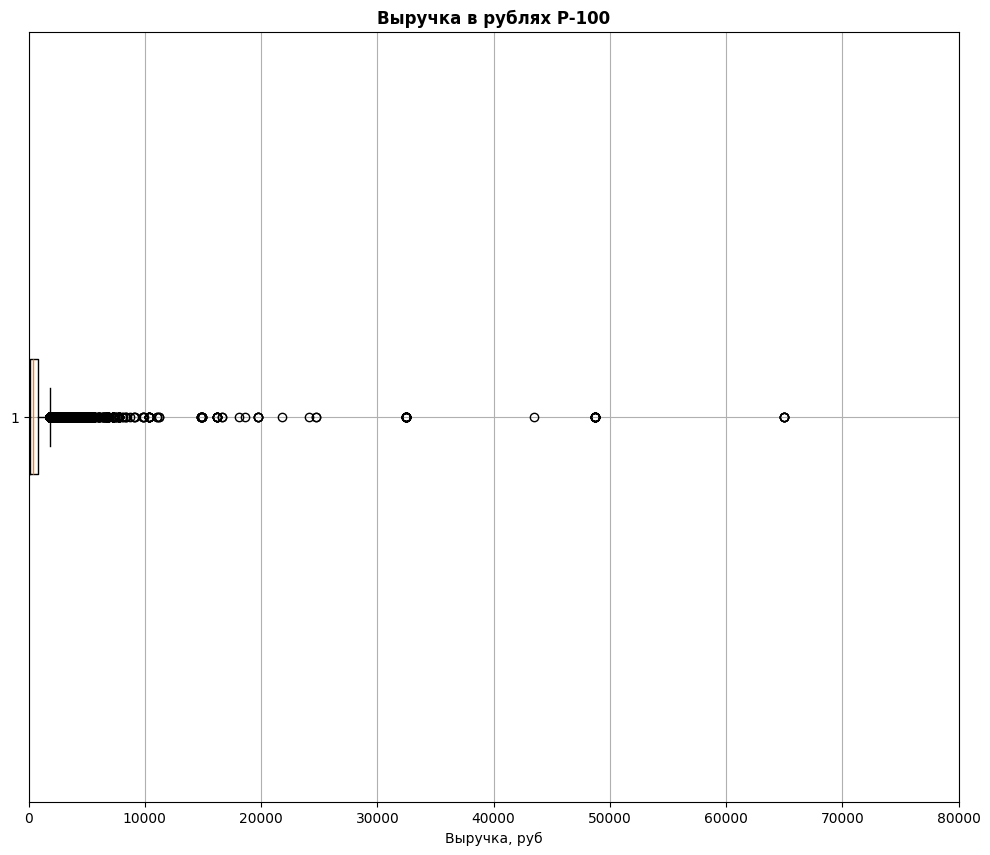

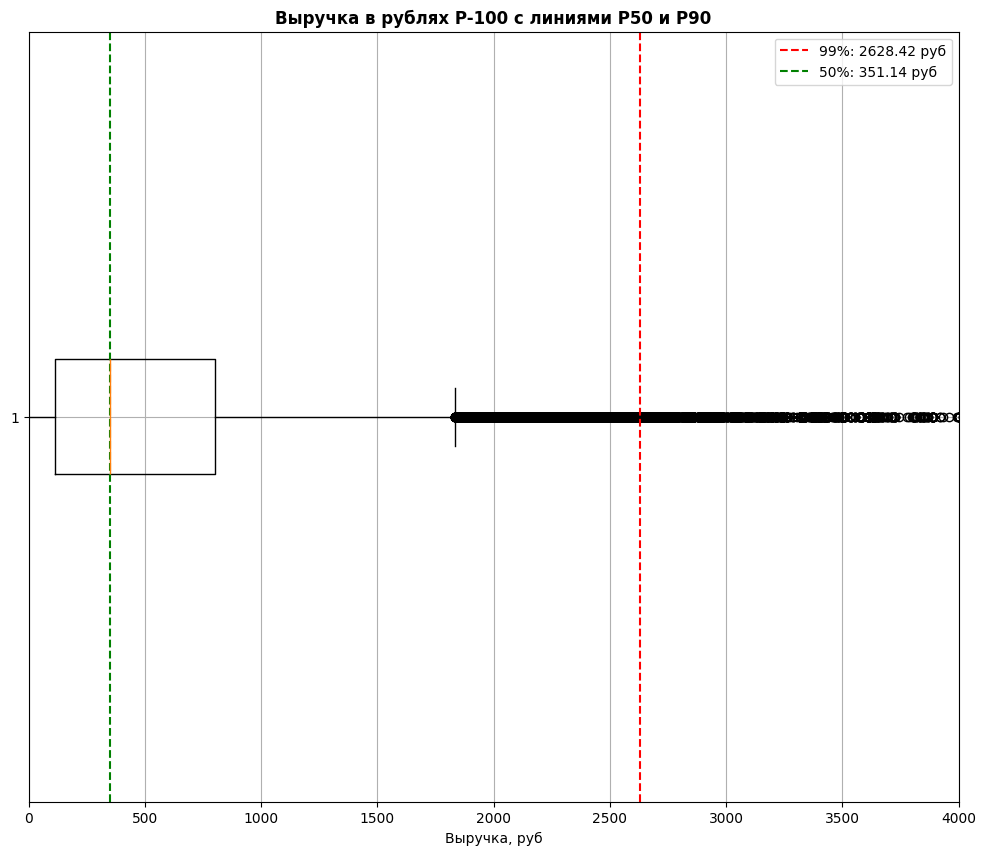

In [23]:
# Рассчитываем персентили для отображения на графике
percentile_99 = df_optimized['revenue_rub'].quantile(0.99)
percentile_50 = df_optimized['revenue_rub'].quantile(0.5)

# Создаем экземпляр без масштабирования
box_plot = MyBoxPlot().df_boxplot(df_optimized['revenue_rub'], title = 'Выручка в рублях P-100', xlabel = 'Выручка, руб', xlim = (0, 80000))
# Создаем экземпляр с ограничением по Х
box_plot = MyBoxPlot().df_boxplot(df_optimized['revenue_rub'], title = 'Выручка в рублях P-100 с линиями P50 и P90', xlabel = 'Выручка, руб', xlim = (0, 4000))
# Добавляем вертикальные линии персентилей
plt.axvline(percentile_99, color='red', linestyle='--', label=f'99%: {percentile_99:.2f} руб')
plt.axvline(percentile_50, color='green', linestyle='--', label=f'50%: {percentile_50:.2f} руб')
plt.legend()
plt.show()


P99 находится в значении 2628 р. 

Медиана выборки P50 находится на уровне 351р.

Это говорит о значительном разбросе значений во встречающихся данных. Дорогие заказы происходят постоянно, но подавляющую часть составляют небольшие по выручке заказы. 
    
Это нормально и может говорить о то, что иногда заказы совершаются централизованно для большого количества людей.

**Проведем аналогичный анализ количества покупаемых билетов:**

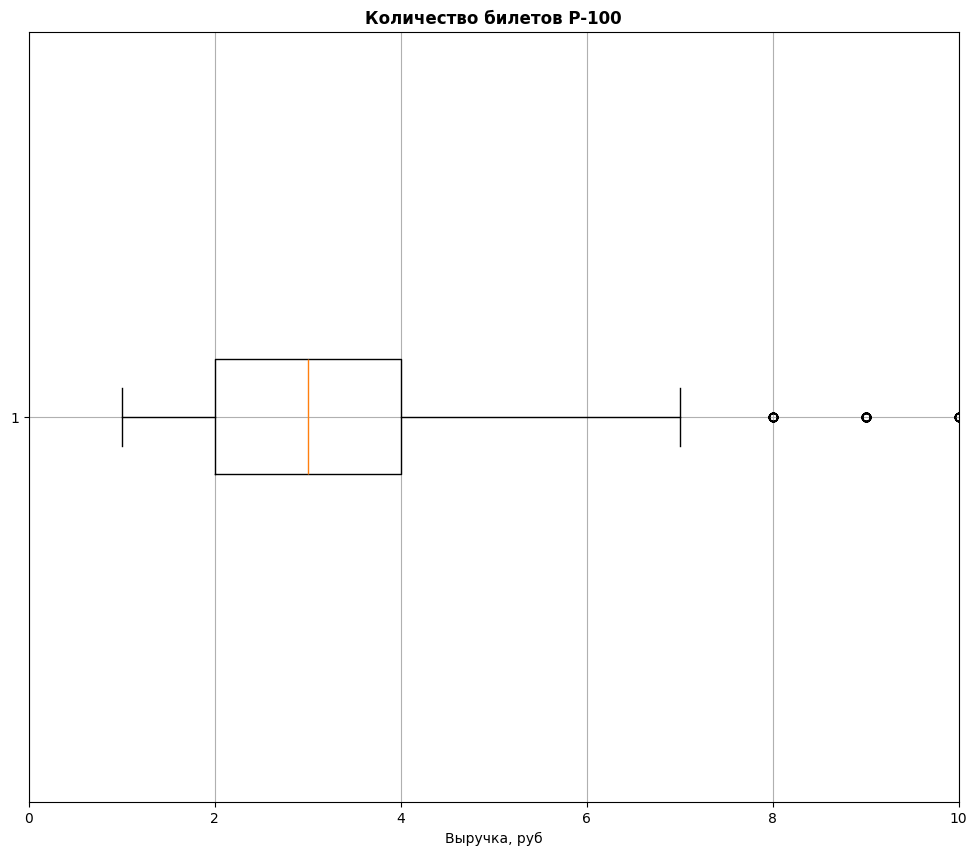

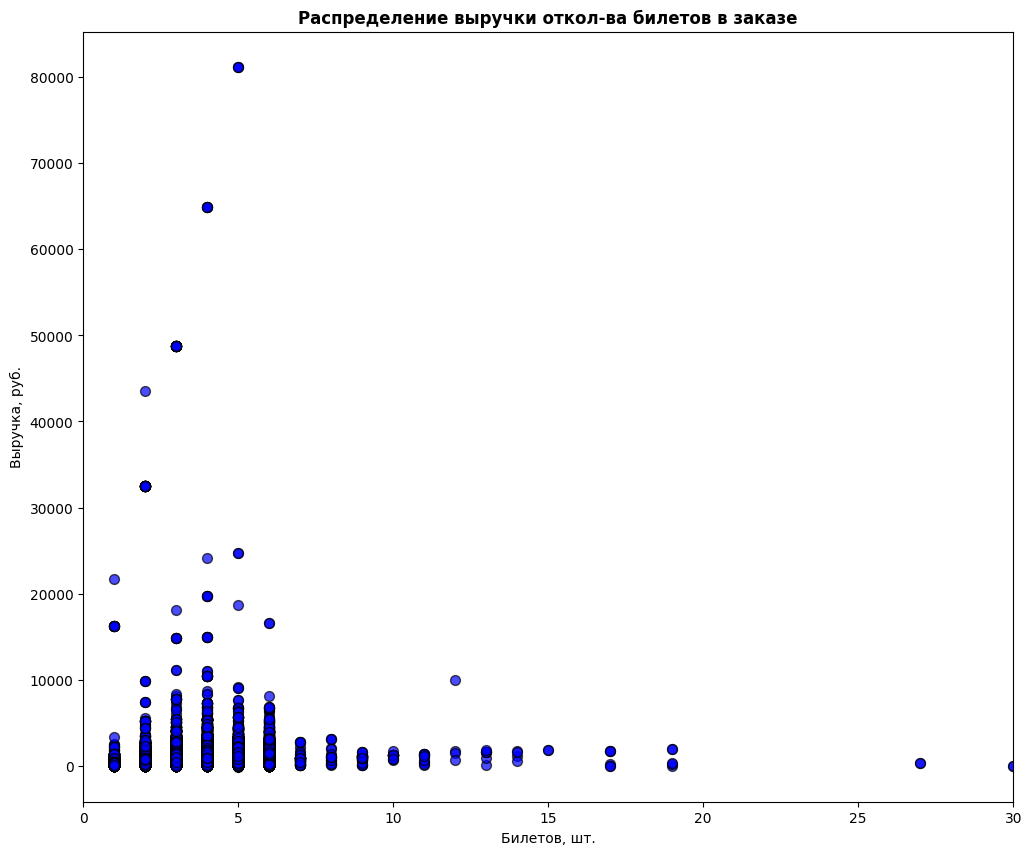

In [24]:
#Строим график с ограничением масштаба

ticket_p100_boxplot = MyBoxPlot().df_boxplot(df_optimized['tickets_count'], title ='Количество билетов P-100', xlabel = 'Выручка, руб', xlim = (0,10))
ticket_p100_scatter = MyBoxPlot().df_scatterplot(df_optimized, x = 'tickets_count', y = 'revenue_rub', title ='Распределение выручки откол-ва билетов в заказе', xlabel = 'Билетов, шт.', ylabel = 'Выручка, руб.', xlim = (0,30))

**Наблюдаются значительные (вылетающие) значения выручки с небольшим количеством билетов. Попробуем найти эти заказы:**

In [25]:
price_plank = 12000 #ценовая планка
display(df_optimized[df_optimized['revenue_rub'] > price_plank].sort_values(by = 'revenue_rub', ascending = False).head(3))
len12k = df_optimized[df_optimized['revenue_rub'] > price_plank].shape[0]
print(f"{len12k} строки")

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,kzt_currency_date,kzt_coef,revenue_rub
183754,96368e5714d1673,mobile,8067453,2024-08-24,2024-08-24 13:56:40,rub,81174.54,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,Облачко,Североярская область,Озёрск,2024-08-24,0.191202,81174.54
122338,5b5714894bd0517,mobile,4113535,2024-08-03,2024-08-03 22:36:13,rub,81174.54,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,Облачко,Североярская область,Озёрск,2024-08-03,0.180536,81174.54
122336,5b5714894bd0517,mobile,4113477,2024-08-03,2024-08-03 22:37:17,rub,81174.54,5,3.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,Облачко,Североярская область,Озёрск,2024-08-03,0.180536,81174.54


83 строки


**Из выдержки заметно, что много заказов приходятся сделаны с мобильного телефона с использованием сервиса "Облачко" и принадлежат  к одному мероприятию - 552398 и имеют выручку 48704 и 16234 (0.33 от 48704). Посмотрим на эти заказы чуть поближе:**

In [26]:
oblako = df_optimized[
    (df_optimized['revenue_rub'] > price_plank) & 
    (df_optimized['service_name'] == 'Облачко')
]
print(f"Дорогих билетов (>{price_plank} р.) от сервиса Облачко: {oblako.shape[0]/len12k:.2%}")

oblako.sort_values(by = 'revenue_rub', ascending = False).head(3)

Дорогих билетов (>12000 р.) от сервиса Облачко: 74.70%


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,kzt_currency_date,kzt_coef,revenue_rub
122336,5b5714894bd0517,mobile,4113477,2024-08-03,2024-08-03 22:37:17,rub,81174.54,5,3.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,Облачко,Североярская область,Озёрск,2024-08-03,0.180536,81174.54
122338,5b5714894bd0517,mobile,4113535,2024-08-03,2024-08-03 22:36:13,rub,81174.54,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,Облачко,Североярская область,Озёрск,2024-08-03,0.180536,81174.54
183754,96368e5714d1673,mobile,8067453,2024-08-24,2024-08-24 13:56:40,rub,81174.54,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,Облачко,Североярская область,Озёрск,2024-08-24,0.191202,81174.54


**Действительно, сервис Облачко продавал билеты на мероприятие 552398 по 16234.91 р. за билет.
При этом валюта в currency_code указана в рублях, значит человеческой ошибки при записи нет.
Цена на 1 билет дорогая относительно остальных значений, но не выглядит аномальной - ничего подозрительного нет.**

**Попробуем проверить другие цены на билеты на то же мероприятие, если они есть.**

In [27]:
not_oblako_tc = df_optimized[df_optimized['event_id'] == 552398& 
    (df_optimized['service_name'] != 'Облачко')]['tickets_count'].sum()


oblako_tc = df_optimized[df_optimized['event_id'] == 552398]['tickets_count'].sum()
oblako_rev = df_optimized[df_optimized['event_id'] == 552398]['revenue_rub'].sum()
print(f"Билетов на мероприятие от Облачка: {oblako_tc}")
print(f"Билетов на мероприятие от других сервисов: {not_oblako_tc}")
print(f"Выручка от мероприятия: {oblako_rev.round(2)}")
print(f"Средняя цена билета: {round(oblako_rev/oblako_tc,2)}")

Билетов на мероприятие от Облачка: 150
Билетов на мероприятие от других сервисов: 0
Выручка от мероприятия: 2435236.23
Средняя цена билета: 16234.91


**Билетов на это мероприятие от других сервисов нет.**

**Цена всех 150 билетов от Облачка стабильна и составляет 16234 р.**

**Аномалий не найдено.**

#### После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

<b>Промежуточный вывод:</b>

<b>* Загрузка данных:</b>

- 290,611 строк, 15 столбцов

- Конвертация валют: создан столбец revenue_rub с единой валютой

- Оптимизация типов данных: уменьшена разрядность datetime и float

- Проверка качества данных: пропуски только в days_since_prev (21,933)

- Анализ выбросов: выявлены дорогие заказы через сервис "Облачко"


<b>* Выручка:</b>

- P99 = 2,628 руб. (99% заказов до этой суммы)

- Медиана = 351 руб.

- Сильный разброс - есть дорогие заказы до 81,174 руб.


<b>* Аномальные выбросы в выручке:</b>

- 74.7% заказов дороже 12,000 руб. приходятся на сервис Облачко

- Продано 150 билетов на мероприятие 552398 по фиксированной цене 16,234.91 руб./билет

- Аномалий не обнаружено - цена стабильна для всех билетов

<b>Данные НЕ были отфильтрованы в процессе предобработки. Сохранен полный объем исходной выгрузки:</b>

In [28]:
print(f"Исходный размер: {df.shape}")
print(f"После предобработки: {df_optimized.shape}")
print(f"Сохранено строк: {df_optimized.shape[0] / df.shape[0]:.1%}")

Исходный размер: (290611, 18)
После предобработки: (290611, 18)
Сохранено строк: 100.0%


---

## Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

#### Задача 3.1. Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


**Отсортируем данные по времени совершения заказа (столбец order_ts)**

In [29]:
dfos = df_optimized.sort_values(by = ['order_ts', 'user_id'], ascending = [False, True]) #отсортированный по времени заказа датафрейм для строительства профиля пользователя
dfos.head(3)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,kzt_currency_date,kzt_coef,revenue_rub
92210,443fe1aafcc96ab,mobile,1696414,2024-10-31,2024-10-31 23:59:54,rub,960.64,3,2.0,505541,3a75769d-5611-45ff-be36-db022e90a171,другое,Билеты без проблем,Североярская область,Озёрск,2024-10-31,0.197383,960.64
70012,3127060e4f02037,mobile,1307582,2024-10-31,2024-10-31 23:59:51,rub,385.81,2,0.0,589958,58051316-2668-4dfb-b442-6859638ea711,концерты,Мой билет,Североярская область,Озёрск,2024-10-31,0.197383,385.81
70011,3127060e4f02037,mobile,1307553,2024-10-31,2024-10-31 23:59:24,rub,578.72,3,0.0,589958,58051316-2668-4dfb-b442-6859638ea711,концерты,Мой билет,Североярская область,Озёрск,2024-10-31,0.197383,578.72


In [30]:
#Создаем пустой датафрейм для отображения профилей пользователей
user_profile = pd.DataFrame() 

#Создаем столбцы с первой и последней датой заказа для каждого пользователя
user_profile = dfos.groupby('user_id')['order_ts'].agg(
    first_order='min',
    last_order='max'
).reset_index()

#Создаем столбец с первым device_type заказа:
#Группируем данные по user_id, выбираем столбец device_type_canonical и выбираем первое значение в сгруппированных значениях. 
#После - сбрасываем индекс и в этом же шаге переименовываем столбец в новый "first_device"
first_order_device = dfos.groupby('user_id')['device_type_canonical'].first().reset_index(name='first_device') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(first_order_device, on='user_id')

#Создаем столбец с первым region_name заказа:
first_order_region= dfos.groupby('user_id')['region_name'].first().reset_index(name='first_region') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(first_order_region, on='user_id')

#Создаем столбец с первым service_name заказа:
first_order_service= dfos.groupby('user_id')['service_name'].first().reset_index(name='first_service') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(first_order_service, on='user_id')

#Создаем столбец с первым event_type_main:
first_order_event_type = dfos.groupby('user_id')['event_type_main'].first().reset_index(name='first_event_type') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(first_order_event_type, on='user_id')

#Создаем столбец с общим колчеством заказов (используем order_id)
total_orders = dfos.groupby('user_id')['order_id'].count().reset_index(name='total_orders') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(total_orders, on='user_id')

#Создаем столбец со средней выручкой с одного заказа пользователя в рублях
user_avg_revenue = dfos.groupby('user_id')['revenue_rub'].mean().round(2).reset_index(name='avg_revenue') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(user_avg_revenue, on='user_id')

#Создаем столбец со средним количеством билетов в заказе (число целых билетов)
user_avg_tickets = dfos.groupby('user_id')['tickets_count'].mean().round(2).reset_index(name='avg_tickets') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(user_avg_tickets, on='user_id')

#Создаем столбец со средним временем между заказами
user_avg_order_lag = dfos.groupby('user_id')['days_since_prev'].first().reset_index(name='avg_order_lag') 
# Объединяем с уже созданным user_profile
user_profile = user_profile.merge(user_avg_order_lag , on='user_id')

#Добавляем бинарные признаки is_two/is_five в зависимости от количества заказов
user_profile['is_two'] = user_profile['total_orders'] >= 2
user_profile['is_five'] = user_profile['total_orders'] >=5

display(user_profile.sort_values(by = 'user_id')) #отображаем отсортированные по user_id строки

print(f"Уникальных user_id: {user_profile['user_id'].nunique()}") #кол-во уникальных user_id

,user_id,first_order,last_order,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue,avg_tickets,avg_order_lag,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4.00,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,За билетом!,другое,2,774.01,3.00,75.0,True,False
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Лугоградская область,Облачко,концерты,3,767.21,2.67,19.0,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.83,4.00,NaN,False,False
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1.50,16.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21928,fff13b79bd47d7c,2024-07-16 22:17:10,2024-10-31 18:31:52,mobile,Яблоневская область,Лови билет!,другое,9,688.04,2.56,24.0,True,True
21929,fff32fc9ad0f9f6,2024-08-15 14:36:28,2024-10-28 23:40:38,desktop,Каменевский регион,Весь в билетах,театр,2,851.00,2.50,74.0,True,False
21930,fffcd3dde79eb2c,2024-06-20 19:57:25,2024-10-30 13:37:43,desktop,Каменевский регион,Прачечная,театр,33,557.91,2.79,3.0,True,True
21931,fffeeb3c120cf0b,2024-09-24 10:07:42,2024-09-24 10:07:42,desktop,Широковская область,Билеты без проблем,стендап,1,661.53,2.00,NaN,False,False


Уникальных user_id: 21933


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [31]:
print(f"\n* Общее число пользователей в выборке: {user_profile['user_id'].count()} польз.")
print(f"\n* Cредняя выручка с одного заказа: {user_profile['avg_revenue'].mean().round(2)} руб.")
print(f"\n* Доля пользователей, совершивших 2 и более заказа: {(user_profile[user_profile['total_orders']>=2]['user_id'].count()/user_profile['user_id'].count()).round(2)}")
print(f"\n* Доля пользователей, совершивших 5 и более заказов: {(user_profile[user_profile['total_orders']>=5]['user_id'].count()/user_profile['user_id'].count()).round(2)}")



* Общее число пользователей в выборке: 21933 польз.

* Cредняя выручка с одного заказа: 574.02 руб.

* Доля пользователей, совершивших 2 и более заказа: 0.62

* Доля пользователей, совершивших 5 и более заказов: 0.29


**На первый взгляд выборка достаточная по объему, распределение значений нормальное. Изучим данные о кол-ве заказов и билетов.**

In [32]:
print(f"Общее число заказов: {user_profile['total_orders'].sum()} заказов")
print(f"Среднее число билетов в заказе: {user_profile['avg_tickets'].mean().round()} билетов")
print(f"Среднее количество дней между покупками: {user_profile['avg_order_lag'].mean().round()} дней")

Общее число заказов: 290611 заказов
Среднее число билетов в заказе: 3.0 билетов
Среднее количество дней между покупками: 18.0 дней


In [33]:
print(f"Дополнительная выгрузка:")
print(f"\n Кол-во заказов:")
print(f"\n* Доля пользователей, совершивших 200 и более заказов: {(user_profile[user_profile['total_orders']>=200]['user_id'].count()/user_profile['user_id'].count()).round(3)}")
print(f"\n* Максимум заказов у пользвателя: {user_profile['total_orders'].max()}")
print(f"\n Кол-во билетов:")
print(f"\n* Максимум билетов в заказе у пользвателя: {dfos['tickets_count'].max()}")
print(f"\n* Максимальное среднее количество билетов среди всех заказов пользвателя: {user_profile['avg_tickets'].max().round()}")

Дополнительная выгрузка:

 Кол-во заказов:

* Доля пользователей, совершивших 200 и более заказов: 0.008

* Максимум заказов у пользвателя: 10251

 Кол-во билетов:

* Максимум билетов в заказе у пользвателя: 57


AttributeError: 'float' object has no attribute 'round'

**Есть выпадающие значения в количестве заказов у одного пользователя, их количество достигает 10 тысяч. Возможно. это связано с тем, что данный пользователь - технический.**

**Среди количества билетов максимум в одном заказе - 57. Это много, но не нереалистично - нередко бывает, что выкупают сектора площадок/кинозалы и т.п. для частных показов или в коммерческих целях (перепродажа).**

**Посмотрим каким персентилем необходимо ограничить данные по заказам:**

In [ ]:
p99_value = user_profile['total_orders'].quantile(.99)
print(f"Максимальное кол-во заказов при ограничении 99P: {p99_value.max()}")

**Максимальное количество заказов стало 152. Это уже хорошее рабочее число - можно ограничить датасет данными по количеству заказов 99 персентилем:**

In [ ]:
user_profile_p99 = user_profile[user_profile['total_orders'] <= p99_value].copy() #С этого момента используется user_profile_p99
display(user_profile_p99.sample(3))
print(f"Объем отфильтрованных данных: {user_profile.shape[0]-user_profile_p99.shape[0]} строк, или {round(((user_profile.shape[0]-user_profile_p99.shape[0])/user_profile.shape[0]*100),2)}%")

In [ ]:
print(f"Статистические данные нового датафрейма user_profile_p99:")
print(f"\n* Общее число пользователей в выборке: {user_profile_p99['user_id'].count()} польз.")
print(f"\n* Cредняя выручка с одного заказа: {user_profile_p99['avg_revenue'].mean().round(2)} руб.")
print(f"\n* Доля пользователей, совершивших 2 и более заказа: {(user_profile_p99[user_profile_p99['total_orders']>=2]['user_id'].count()/user_profile_p99['user_id'].count()).round(2)}")
print(f"\n* Доля пользователей, совершивших 5 и более заказов: {(user_profile_p99[user_profile_p99['total_orders']>=5]['user_id'].count()/user_profile_p99['user_id'].count()).round(2)}")
print(f"\n* Общее число заказов: {user_profile_p99['total_orders'].sum()} заказов")
print(f"\n* Среднее число билетов в заказе: {user_profile_p99['avg_tickets'].mean().round()} билетов")
print(f"\n* Среднее количество дней между покупками: {user_profile_p99['avg_order_lag'].mean().round()} дней")

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [ ]:
categories = ['first_event_type', 'first_device', 'first_region', 'first_service']

# Создаем отдельный анализ для каждой категории
for category in categories:
    segments = user_profile_p99.groupby(category)
    segment_sizes = segments.size().sort_values(ascending=False)
    segment_shares = (segment_sizes / len(user_profile_p99) * 100).round(2)
    is_two_percentage = (segments['is_two'].mean() * 100).round(2)
    
    segment_analysis = pd.DataFrame({
        'user_count': segment_sizes,
        'percentage': segment_shares,
        'is_two_percentage': is_two_percentage
    })
    
    print(f"\n Анализ категории {category}:")
    display(segment_analysis.sort_values(by='user_count', ascending = False).head(10))
    
total_segments = sum(user_profile_p99[category].nunique() for category in categories)
print(f"Общее количество сегментов: {total_segments}")

**В выборке получилось 124 сегмента. Распределение пользователей по сегментам неравномерное.**

**Есть выраженные "точки входа" - сегменты с наибольшим числом пользователей, это сегменты:**
- Концерты и театр 
- Каменевский регион и Североярская область
- Сервисы "Билеты без проблем", "Мой билет", "Лови билет!"

---

#### Задача 4.1.2. Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [ ]:
# Количество 2+ заказов по типам мероприятий
is_two_by_event = user_profile_p99.groupby('first_event_type')['is_two'].mean().round(2)
print("Количество пользователей с 2+ заказами по типам мероприятий:")
display(is_two_by_event.sort_values(ascending = False).head(10))

# Количество 2+ заказов по типам платформ
is_two_by_device = user_profile_p99.groupby('first_device')['is_two'].mean().round(2)
print("Количество пользователей с 2+ заказами по типам платформ:")
display(is_two_by_device.sort_values(ascending = False).head(10))

# Количество 2+ заказов по регионам
is_two_by_regon = user_profile_p99.groupby('first_region')['is_two'].mean().round(2)
print("Количество пользователей с 2+ заказами по регионам:")
display(is_two_by_regon.sort_values(ascending = False).head(10))

# Количество 2+ заказов по сервисам
is_two_by_service = user_profile_p99.groupby('first_service')['is_two'].mean().round(2)
print("Количество пользователей с 2+ заказами по сервисам:")
display(is_two_by_service.sort_values(ascending = False).head(10))

In [ ]:
categories = ['first_event_type', 'first_device', 'first_region', 'first_service']
# Анализ возвращаемости по отдельным категориям

category = 'first_event_type'
print(f"\nАнализ возвращаемости по {category}:")
returning_by_category = user_profile_p99.groupby(category)['is_two'].mean().mul(100).round(2).sort_values(ascending=True).tail(10)
MyBoxPlot().df_barh(returning_by_category,
                   title=f'Возвращаемость по {category}',
                   xlabel='Доля с 2+ заказами (%)',
                   ylabel=category)


In [ ]:
category = 'first_device'
print(f"\nАнализ возвращаемости по {category}:")
returning_by_category = user_profile_p99.groupby(category)['is_two'].mean().mul(100).round(2).sort_values(ascending=True).tail(10)
MyBoxPlot(figsize=(4,4)).df_bar(returning_by_category,
                   title=f'Возвращаемость по {category}',
                   xlabel='Доля с 2+ заказами (%)',
                   ylabel=category)

In [ ]:
category = 'first_region'
print(f"\n Анализ возвращаемости по {category}:")
returning_by_category = user_profile_p99.groupby(category)['is_two'].mean().mul(100).round(2).sort_values(ascending = True).tail(10)
MyBoxPlot().df_barh(returning_by_category,
                       title=f'Возвращаемость по {category}',
                       xlabel='Доля с 2+ заказами (%)',
                       ylabel=category)



In [ ]:
category = 'first_service'
print(f"\n Анализ возвращаемости по {category}:")
returning_by_category = user_profile_p99.groupby(category)['is_two'].mean().mul(100).round(2).sort_values(ascending = True).tail(10)
MyBoxPlot().df_barh(returning_by_category,
                       title=f'Возвращаемость по {category}',
                       xlabel='Доля с 2+ заказами (%)',
                       ylabel=category)

**Распределение пользователей по сегментам**

**Крупнейшие сегменты:**

- Концерты: 9,257 пользователей (56% от общей выборки)

- Другое: 5,137 пользователей (31%)

- Театр: 4,576 пользователей (28%)

**Меньшие сегменты:**

- Спорт: 1,042 пользователя

- Стендап: 1,055 пользователей

- Выставки: 439 пользователей

- Ёлки: 208 пользователей

**Лидеры по потворным заказам:**

- Ёлки - 79.3%

- Спорт - 66.2%

- Выставки - 66.1%

- Театр: 66.0%

- Концерты: 60.6%

- Стендап - 58.7%

**Успешные "точки входа"**
Ёлки, выставки и спорт демонстрируют высокую долю повторных заказов (66-79%). Эти сегменты можно считать наиболее перспективными для привлечения лояльной аудитории.

Однако, хоть сегмент с первым типом мероприятия "Елки" показывают отличную возвращаемость, это самый маленький сегмент (208 пользователей), что требует осторожности в интерпретации результатов. Предположительно, это небольшой слой клиентов с детьми возраста до 10 лет, который не может показывать большой рост, но может показывать лояльность к неоднократным заказам.

Спорт и выставки сочетают хороший размер выборки и хорошую возвращаемость - предположительно, это связано с хоббийной ориентацией сегментов - будучи увлеченными, люди будут склонны посещать такие мероприя повторно.

Самые крупные сегменты с хорошей возвращаемостью - концерты, театр.  Поскольку это одни из самых популярных направлений культурных мерпориятий, это ожидаемая картина для этих сегментов. Чуть меньший % возвращаемости может быть связан с повышенной выборочностью типов мероприятий среди пользователей (определенные типы концертов/постановок) и стоимостью билетов.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [ ]:
categories = ['first_event_type','first_region']

# Создаем отдельный анализ для каждой категории
for category in categories:
    segments = user_profile_p99.groupby(category)
    segment_sizes = segments.size().sort_values(ascending=False)
    segment_shares = (segment_sizes / len(user_profile_p99) * 100).round(2)
    is_two_percentage = (segments['is_two'].mean() * 100).round(2)
    
    segment_analysis = pd.DataFrame({
        'user_count': segment_sizes,
        'percentage': segment_shares,
        'is_two_percentage': is_two_percentage
    })
    
    print(f"\n Анализ категории {category}:")
    display(segment_analysis.sort_values(by='user_count', ascending = False).head(10))
    
total_segments = sum(user_profile_p99[category].nunique() for category in categories)
print(f"Общее количество сегментов: {total_segments}")

**Гипотеза 1.** Пользователи, которые совершили первый заказ на спортивные мероприятия, дейтсвительно совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты. Спорт - 66.2% повторных заказов, Концерты - 60.6% повторных заказов.
Однако, нельзя говорит о существенной разнице в возвращаемости.

**Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, доля повторных заказов не всегда выше, чем в менее активных регионах. Это можно увидеть на примере Каменевского региона с 6974 пользователей и 61.6% повторных заказов и, например, Светлополянского округа с 515 пользователей и 69.3% повторных заказов.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [ ]:
# Разделяем пользователей на две группы
one_order_users = user_profile_p99[user_profile_p99['is_two'] == False]
returning_users = user_profile_p99[user_profile_p99['is_two'] == True]


# Настраиваем одинаковые интервалы для обеих групп
bins = 300
alpha = 0.5
plt.figure(figsize=(10,6))

plt.hist(one_order_users['avg_revenue'], 
         bins=bins, alpha=alpha, color='red', 
         label='Один заказ', density=True)

plt.hist(returning_users['avg_revenue'], 
         bins=bins, alpha=alpha, color='blue', 
         label='2+ заказов', density=True)

plt.xlabel('Средняя выручка с билета, руб.')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки с билета\nмежду пользователями с одним и несколькими заказами')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0,4000)
plt.show()

**1. В каких диапазонах средней выручки концентрируются пользователи из каждой группы?**
Пользователи из группы "1 заказ" концентрируются в диапазоне до 1000 рублей, с пиком в диапазоне до 250 рублей.
Пользователи из группы "2 и более заказа" также концентрируются в диапазоне до 1000 рублей, однако пик смещен вправо на уровень 500 рублей
**2.Есть ли различия между группами?**
Группа "1 заказ" больше по количеству пользователей и имеет равномерный быстрый спуск с "хвостом" справа, в то время как группа "2 и более заказа" имеет чуть более равномерное распеделение, похожее на нормальное Гауссово распределение. Однако, так же имеет хвост в правой части.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [ ]:
# Создаем новый столебц по количеству заказов от 2 до 4
user_profile_p99['is_two_to_four'] = (user_profile_p99['total_orders'] >= 2) & (user_profile_p99['total_orders'] <= 4)
display(user_profile_p99.sample(3))

#Создаем группы по количеству заказов для отображения на графиках

users_2to4_orders = user_profile_p99[user_profile_p99['is_two_to_four'] == True]
users_5_orders = user_profile_p99[user_profile_p99['is_five'] == True]

In [ ]:
# Строим сравнительные гистограммы
fig, ax = plt.subplots(figsize=(12, 6))

# Гистограмма распределения
bins = 300
alpha = 0.5

ax.hist(users_2to4_orders['avg_revenue'], 
        bins=bins, alpha=alpha, color='orange', 
        label='2-4 заказа', density=True)

ax.hist(users_5_orders['avg_revenue'], 
        bins=bins, alpha=alpha, color='green', 
        label='5+ заказов', density=True)

ax.set_xlabel('Средняя выручка от заказа, руб.')
ax.set_ylabel('Плотность распределения')
ax.set_title('Сравнение распределения средней выручки\nмежду пользователями с 2-4 и 5+ заказами')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 4000)
plt.show()

**Есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?**

Графики двух групп отличаются значительно - график группы "2-4 заказов" имеет довольно гладкое постепенное убывание числа пользователей при увеличении значений средней выручки.
Основной объем пользователей находится в пределах до 1000 рублей, однако пик приходится на минимальные значения в районе 100 рублей.

Для графика "5+ заказов" присуще близкое к нормальному распределение с хвостом в правой части. Хотя большинство значений приходится на объем до 1000 рублей, средняя цена стремится к уровню 600 рублей.

Это может говорить о том, что пользователи в группе "2-4 заказа" склонны покупать в примерно схожем диапазоне выручки, что и в первый раз, в то время как в группе "5+ заказов"  пользователи уже охотнее покупают дорогие билеты или бОльшее количество билетов в рамках одного заказа.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [ ]:
#На текущий момент:
display(user_profile_p99.sample(1))

In [ ]:
#Делим пользователей на группы по среднему количеству билетов для задачи.
#Добавим эти столбцы в сущетсвующую таблицу, на случай если они пригодятся в будущем - это полезные маркеры.

user_profile_p99['ticket_segment'] = [
    'one_to_two' if 1 <= x < 2 else
    'two_to_three' if 2 <= x < 3 else
    'three_to_five' if 3 <= x < 5 else
    'five_plus' if x >= 5 else
    None
    for x in user_profile_p99['avg_tickets']
]

ticket_segments_analysis = user_profile_p99.groupby('ticket_segment').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(2)

tickets_segment_order = ['one_to_two', 'two_to_three', 'three_to_five', 'five_plus']
ticket_segments_analysis = ticket_segments_analysis.reindex(tickets_segment_order)

#Проверим результат:
display(ticket_segments_analysis)

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(ticket_segments_analysis.index, ticket_segments_analysis['user_id'])
plt.xlabel('Сегменты по количеству билетов')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по сегментам')
plt.show()

In [ ]:
tsarr = MyBoxPlot(figsize=(6,4)).df_barh(ticket_segments_analysis['is_two'].sort_values(ascending=True).tail(), title = 'Доля повторных покупок по сегментам')

In [ ]:
#Блок описательной статистики
print("Описательная статисткиа avg_tickets_count:")
print(" ")
print(f"Среднее количество билетов: {user_profile_p99['avg_tickets'].mean():.2f}")
print(f"Медиана количества билетов: {user_profile_p99['avg_tickets'].median():.2f}")
print(" ")
print(f"Размах: {(user_profile_p99['avg_tickets'].max()-user_profile_p99['avg_tickets'].min()):.2f}")
print(f"Стандартное отклонение: {user_profile_p99['avg_tickets'].var():.2f}")
print(f"Стандартное отклонение: {user_profile_p99['avg_tickets'].std():.2f}")

**Как распределены пользователи по сегментам — равномерно или сконцентрировано?**

Пользователи распределены неравномерно - большая часть пользователей (около 18500) находится в сегментах "2-3 билетов" и "3-5 билетов" в заказе - среди этих сегментов пользователи распределены практически поровну - 9100 и 9400 пользователей на сегмент соответственно.

В целом, это отражает нормальную картину - массовые мероприятия чаще посещают компаниями - семейные/около семейные или дружеские группы. 

Сегменту "1-2 билета" принадлежит 2400 пользователей, сегмент "5+ билетов" - наименьший, с около 700 пользователей.

**Есть ли сегменты с аномально высокой или низкой долей повторных покупок?**

Повторные покупки по сегментам распределены более равномерно, аномально высоких значений нет.
В сегменте "2-3 билета" 74% повторных показов, сегменты "1-2 билета" и "3-5 билетов" имеют почти равный % повторных заказов 51% и 54% соответственно.

Сегмент "5+ билетов" можно было бы назвать привлекающим внимание низким уровнем повторных заказов, однако, это может говорить о том, что это могут быть более специализированные покупки - семейные редкие походы или корпоративные мероприятия.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [ ]:
user_profile_p99['first_order_weekday'] = pd.to_datetime(user_profile_p99['first_order']).dt.day_of_week + 1 #добавим 1 чтобы Понедельник = 1

fo_dow_segment_analysis = user_profile_p99.groupby('first_order_weekday').agg({
    'user_id': 'count',
    'is_two': 'mean'})

# Переименовываем числовые значения дней недели:
weekday_names = {
    1: 'Понедельник',
    2: 'Вторник', 
    3: 'Среда',
    4: 'Четверг',
    5: 'Пятница',
    6: 'Суббота',
    7: 'Воскресенье'
}

fo_dow_segment_analysis.index = fo_dow_segment_analysis.index.map(weekday_names)

display(fo_dow_segment_analysis) #Проверим результат

In [ ]:
dowvis = MyBoxPlot(figsize=(8,6)).df_bar(fo_dow_segment_analysis['user_id'], title = 'Количество пользователей по дням недели первого заказа')

In [ ]:
dowvis = MyBoxPlot(figsize=(8,6)).df_barh(fo_dow_segment_analysis['is_two'][::-1], title = 'Доля повторных заказов среди пользователей по дням недели первого заказа')

**Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?**

Данные распределены достаточно равномерно. Первый заказ реже встречается в воскресенье - что довольо логично, поскольку это выходной день и люди чуть реже занимаются бытовыми делами в последний день недели.

Доля повторных заказов по дням недели практически не отличается.

Можно с уверенностью сказать, что день первого заказа не влияет на вероятность возврата клиента.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [ ]:
display(user_profile_p99.sample(1)) #Проверяем наличие группы 2-4 заказа

In [ ]:
time_2_4  = user_profile_p99[user_profile_p99['is_two_to_four'] == True]['avg_order_lag'].mean().round()
time_5  = user_profile_p99[user_profile_p99['is_five'] == True]['avg_order_lag'].mean().round()

print(f"Средний интервал между заказами: \n Группа '2-4 заказа': {time_2_4} дн.,\n Группа '5+ заказов': {time_5}")
print("")
# Медианы для сравнения
median_2_4 = user_profile_p99[user_profile_p99['is_two_to_four'] == True]['avg_order_lag'].median()
median_5 = user_profile_p99[user_profile_p99['is_five'] == True]['avg_order_lag'].median()
print(f"Медиана для 2-4 заказов: {median_2_4:.2f} дней")
print(f"Медиана для 5+ заказов: {median_5:.2f} дней")
print("")
# Стандартные отклонения
std_2_4 = user_profile_p99[user_profile_p99['is_two_to_four'] == True]['avg_order_lag'].std()
std_5 = user_profile_p99[user_profile_p99['is_five'] == True]['avg_order_lag'].std()
print(f"Стандартное отклонение для 2-4 заказов: {std_2_4:.2f} дней")
print(f"Стандартное отклонение для 5+ заказов: {std_5:.2f} дней")

Разница между группами 11.41 дня (12 полных дней)

Лояльные пользователи (5+ заказов) совершают покупки в 2 раза чаще.

Пользователи с 2-4 заказами покупают реже, поэтому пользователи с 2-4 заказами - целевая группа для увеличения частоты покупок в будущем.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [ ]:
display(user_profile_p99.sample(1))

In [ ]:
# Создаем сегменты заказов
categories_cols = ['first_device','first_region', 'first_service', 'first_event_type']
interval_cols = ['total_orders', 'avg_revenue', 'avg_tickets', 'avg_order_lag']

corr_columns = categories_cols + interval_cols

phi_k_matrix = user_profile_p99[corr_columns].phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(8, 6))
sns.heatmap(data=phi_k_matrix, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm', center=0.5)
plt.title('Корреляция total_orders')
plt.tight_layout()
plt.show()

Корреляция действительно слабая. Попробуем создать матрицу, исключив total_orders, но включив сегменты:

In [ ]:
#Выделим новый сегмент "1 заказ":
user_profile_p99['is_one'] = user_profile_p99['total_orders'] == 1

display(user_profile_p99.sample(1))

In [ ]:

# Создаем сегменты заказов
categories_cols = ['first_device','first_region', 'first_service', 'first_event_type']
interval_cols = ['avg_revenue', 'avg_tickets', 'avg_order_lag','is_one', 'is_two_to_four', 'is_five']

corr_columns = categories_cols + interval_cols

phi_k_matrix = user_profile_p99[corr_columns].phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 8))
sns.heatmap(data=phi_k_matrix, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm', center=0.5)
plt.title('Корреляция сегментов total_orders')
plt.tight_layout()
plt.show()


**Какие признаки наиболее связаны с количеством заказов?**

В обоих матрицах с количеством заказов имеется средняя связь по признаку avg_tickets.
В категоризированной матрице эта связь прослеживается для категорий "1 заказ" и "5+ заказов". Для категории "2-4 заказа" связь слабая.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Общий вывод и рекомендации**

**Информация о данных:**

**1. Обработка данных:**

* Загружено 290,611 заказов от 21,933 уникальных пользователей

* Оптимизированы типы данных для эффективной работы

* Проведена конвертация валют из тенге в рубли с использованием актуальных курсов

* Выполнена фильтрация аномальных значений по персентилю 99 (1% пользователей с >152 заказами), стало 21,714 уникальных пользователей


**Основные результаты анализа**

**1. Объем выборки и распределение**
* 21,714 пользователей после фильтрации выбросов

    Распределение по заказам: 
* 1 заказ: 8,471 пользователь (39%)

* 2 заказа: 4,132 пользователя (19%)

* 3 заказа: 2,115 пользователей (10%)

* 4 заказа: 1,045 пользователей (5%)

* 5+ заказов: 5,951 пользователь (28%)

    Другие интересные показатели: средняя выручка 574₽, 2.76 билета/заказ, 61% возвращаемость

**2. Признаки первого заказа и возврат:**

Высокая возвращаемость: 

Типы мероприятий: ёлки (79%), спорт (66%), выставки (66%), театр (66%)

Регионы-лидеры: Берестовский округ - 77%, Озернопольская область - 77% Верхозёрский край - 100% (не показательно - мало пользователей)

Сервисы: Билет по телефону - 89%, Crazy ticket! - 74%, Дырокол - 100% (не показательно - мало пользователей)

Устройства: desktop (64%), mobile (61%)

**3. Выручка и билеты к возвратам**

Выручка: одинаковая концентрация до 1000₽, но у лояльных пик смещен к 500₽

Билеты: сегмент "2-3 билета" имеет максимальную возвращаемость 74%

Возможная аномалия: сегмент "5+ билетов" показывает низкую возвращаемость 19%

**4. Временные характеристики**

День недели: не влияет на возвращаемость (все дни 59-63%)

Интервалы: 5+ заказов - 12 дней между покупками, 2-4 заказа - 23 дня

Вывод: Пользователи с 5+ билетами покупают в 2 раза чаще

**5. Корреляционный анализ с числом покупок**

Сегменты "1 заказ" и "5+ заказов" имеют более выраженные паттерны поведения

Сегмент "2-4 заказа" имеет слабо выраженную связь.

Все остальные параметры имеют слабо выраженную связь с числом покупок

**Дополнительные выводы:**

1. Типы мероприятий: 

Концерты: 42% аудитории, но только 61% возвращаемости

Ёлки: 1% аудитории, но 79% возвращаемости - нишевый сегмент с хорошей возвращаемостью

2. Устройства: 

83% пользователей использую mobile платформу, но имеют возвращаемость на 3% ниже desktop - возможно, проблема удобства интерфейса

3. Сервисы: 

Сервис "Билеты без проблем": 22% пользователей, но не очень высокая возвращаемость 58% - возможно, низкие цены, но невысокое качество сервиса. Или широкий выбор, но нелояльные цены/низкое качество сервиса.

4. Количество билетов: 

2-3 билета: 74% возвращаемости - золотая середина.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**